In [2]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.5 MB/s eta 0:00:00


In [18]:
# Install required libraries
!pip install PyPDF2 pandas nltk textblob wordcloud scikit-learn matplotlib

# Import all necessary libraries
import re
import string
import pandas as pd
import PyPDF2
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from google.colab import files # For file upload

# Download required NLTK data (if not already downloaded)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

True

In [19]:
# Get the file path of the uploaded file
pdf_path = "/content/drive/MyDrive/NLP/40th Annual Report 2024-2025.pdf"

In [22]:
print("--- Step 1 & 2: Reading PDF and Saving to DataFrame ---")
pages_data = []

with open(pdf_path, 'rb') as pdf_file_obj:
    pdf_reader = PyPDF2.PdfReader(pdf_file_obj)
    num_pages = len(pdf_reader.pages)

    print(f"Found {num_pages} pages in the PDF.")

    for page_num in range(num_pages):
        page_obj = pdf_reader.pages[page_num]
        text = page_obj.extract_text()
        pages_data.append({'page': page_num + 1, 'text': text})

df = pd.DataFrame(pages_data)
print("PDF read successfully and saved to DataFrame.")
print("\nDataFrame created. First 5 rows:")
print(df.head())

--- Step 1 & 2: Reading PDF and Saving to DataFrame ---
Found 171 pages in the PDF.
PDF read successfully and saved to DataFrame.

DataFrame created. First 5 rows:
   page                                               text
0     1  Registered Office\nOffice No. 3, Level 2, Cent...
1     2  foundation helped us navigate uncertainty. How...
2     3  Audacious, Agile & Ambitious\nProgress rarely ...
3     4  About the Company\nBuilding Beyond Boundaries\...
4     5  At HFL, our strategic vision and adaptability ...


In [23]:
print("\n--- Step 3: Preprocessing Text ---")

stop_words = set(stopwords.words('english'))
cleaned_texts = []

for text in df['text']:
    if not isinstance(text, str):
        cleaned_texts.append("")
        continue

    # Convert to lower case
    text = text.lower()
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Join tokens back into a string
    cleaned_text = " ".join(filtered_tokens)
    cleaned_texts.append(cleaned_text)

df['cleaned_text'] = cleaned_texts
print("Text preprocessing complete. Sample comparison:")
print(df[['page', 'cleaned_text']].head())


--- Step 3: Preprocessing Text ---
Text preprocessing complete. Sample comparison:
   page                                       cleaned_text
0     1  registered office office level centriumphoenix...
1     2  foundation helped us navigate uncertainty howe...
2     3  audacious agile ambitious progress rarely come...
3     4  company building beyond boundaries hindustan f...
4     5  hfl strategic vision adaptability positioned u...


In [24]:
print("\n--- Step 4: Sentence Tokenization and Sentiment Analysis ---")
sentiments = []

for index, row in df.iterrows():
    if not isinstance(row['text'], str):
        continue

    sentences = sent_tokenize(row['text'])
    for sentence in sentences:
        blob = TextBlob(sentence)
        polarity = blob.sentiment.polarity

        if polarity > 0.1:
            sentiment = 'Positive'
        elif polarity < -0.1:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'

        sentiments.append({'sentence': sentence, 'polarity': polarity, 'sentiment': sentiment})

sentiment_df = pd.DataFrame(sentiments)
print("Sentiment analysis complete.")
print("\nSample Sentiment Analysis Results:")
print(sentiment_df.head())

print("\nOverall Sentiment Distribution:")
print(sentiment_df['sentiment'].value_counts())

# Save results to a CSV file in the Colab environment
sentiment_df.to_csv('sentiment_analysis.csv', index=False)
print("\nFull sentiment analysis results saved to 'sentiment_analysis.csv'")
print("You can find this file in the file panel on the left.")


--- Step 4: Sentence Tokenization and Sentiment Analysis ---
Sentiment analysis complete.

Sample Sentiment Analysis Results:
                                            sentence  polarity sentiment
0                      Registered Office\nOffice No.  0.000000   Neutral
1  3, Level 2, Centrium,Phoenix Market City,15 La...  0.000000   Neutral
2  : L15139MH1984PLC31600340th ANNUAL REPORT\n202...  0.151786  Positive
3         foundation helped us navigate uncertainty.  0.000000   Neutral
4  However, while \nour stability r emained intac...  0.000000   Neutral

Overall Sentiment Distribution:
sentiment
Neutral     3617
Positive     790
Negative     255
Name: count, dtype: int64

Full sentiment analysis results saved to 'sentiment_analysis.csv'
You can find this file in the file panel on the left.


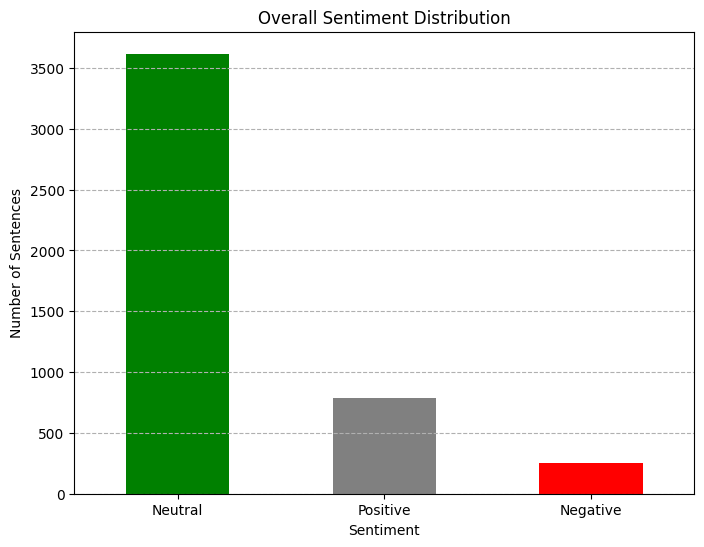

In [31]:
import matplotlib.pyplot as plt

# Get the sentiment counts
sentiment_counts = sentiment_df['sentiment'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Sentences')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

In [32]:
print("\n--- Step 5: Word Tokenization Example ---")

# Check if the first page has any cleaned text
if not df['cleaned_text'].iloc[0].strip():
    print("First page has no cleaned text to tokenize.")
else:
    sample_tokens = word_tokenize(df['cleaned_text'].iloc[0])
    print(f"Tokens from the first page's cleaned text (first 20):")
    print(sample_tokens[:20])


--- Step 5: Word Tokenization Example ---
Tokens from the first page's cleaned text (first 20):
['registered', 'office', 'office', 'level', 'centriumphoenix', 'market', 'city', 'lal', 'bahadur', 'shastri', 'roadkurla', 'w', 'mumbai', 'indiacin', 'lmhplcth', 'annual', 'report', 'hindustan', 'foods', 'limited']


In [33]:
print(f"\n--- Step 6.1: Top 20 Most Frequent Words ---")

# Join all cleaned text into one giant string and split into words
word_list = ' '.join(df['cleaned_text'].astype(str)).split()

if not word_list:
    print("No words to count after preprocessing.")
else:
    counts = Counter(word_list)
    most_common = counts.most_common(20)

    freq_df = pd.DataFrame(most_common, columns=['Word', 'Frequency'])
    print(freq_df.to_string(index=False))


--- Step 6.1: Top 20 Most Frequent Words ---
      Word  Frequency
   company       1011
      year        896
     march        721
 financial        643
   limited        533
statements        532
    report        477
   nancial        477
        rs        476
    assets        466
     total        354
     ended        342
  business        316
 directors        312
   current        310
     board        306
 corporate        305
   private        275
    shares        273
     value        268



--- Step 6.2: Generating Word Cloud ---


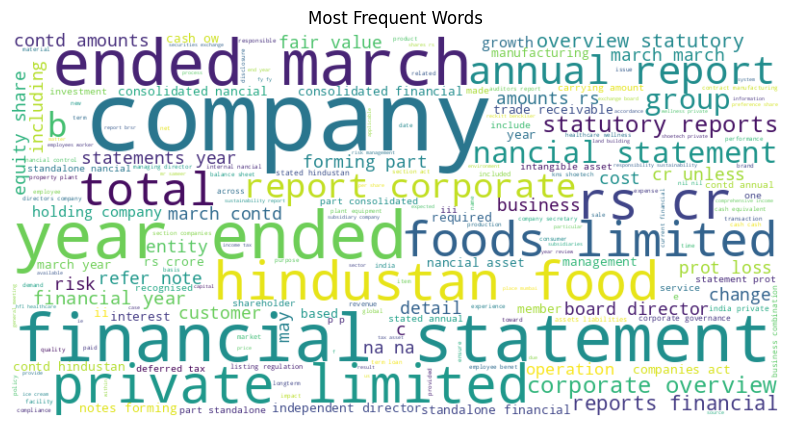

Word cloud generated and saved as 'wordcloud.png'


In [27]:
print("\n--- Step 6.2: Generating Word Cloud ---")

full_text = ' '.join(df['cleaned_text'].astype(str))

if not full_text.strip():
    print("Cannot generate word cloud from empty text.")
else:
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='viridis').generate(full_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Frequent Words')
    plt.savefig('wordcloud.png')
    plt.show() # This line displays the plot in Colab

    print("Word cloud generated and saved as 'wordcloud.png'")

In [28]:
print("\n--- Step 7: Creating TF-IDF Document Term Matrix ---")

# Use the cleaned text from each page as a document
text_corpus = df['cleaned_text'].astype(str)

vectorizer = TfidfVectorizer(max_df=0.9, min_df=5,
                             stop_words='english',
                             ngram_range=(1,2))

tfidf_matrix = vectorizer.fit_transform(text_corpus)
tfidf_matrix = vectorizer.fit_transform(text_corpus)

print("TF-IDF matrix created.")
print(f"Shape of the TF-IDF matrix: {tfidf_matrix.shape}")

# Display a sample of the matrix
feature_names_sample = vectorizer.get_feature_names_out()[:10]

# Ensure we don't try to index more pages than we have
num_sample_pages = min(5, tfidf_matrix.shape[0])

tfidf_sample_df = pd.DataFrame(
    tfidf_matrix[:num_sample_pages, :10].toarray(),
    columns=feature_names_sample,
    index=[f'Page {i+1}' for i in range(num_sample_pages)]
)

print("\nSample of TF-IDF Matrix (first 5 pages, first 10 features):")
print(tfidf_sample_df)


--- Step 7: Creating TF-IDF Document Term Matrix ---
TF-IDF matrix created.
Shape of the TF-IDF matrix: (171, 2881)

Sample of TF-IDF Matrix (first 5 pages, first 10 features):
        aairs  aairs company   ab   ability  able  abled  accelerated  \
Page 1    0.0            0.0  0.0  0.000000   0.0    0.0          0.0   
Page 2    0.0            0.0  0.0  0.000000   0.0    0.0          0.0   
Page 3    0.0            0.0  0.0  0.073332   0.0    0.0          0.0   
Page 4    0.0            0.0  0.0  0.056344   0.0    0.0          0.0   
Page 5    0.0            0.0  0.0  0.047091   0.0    0.0          0.0   

        accepted  access  accessed  
Page 1       0.0     0.0       0.0  
Page 2       0.0     0.0       0.0  
Page 3       0.0     0.0       0.0  
Page 4       0.0     0.0       0.0  
Page 5       0.0     0.0       0.0  



--- Step 8: Building Topic Model (LDA) ---

Top words per topic:
Topic #1: meeting held | amendments | id | footwear | shareholders holding | applicable company | transformation | pursuant section | wholly | utilised


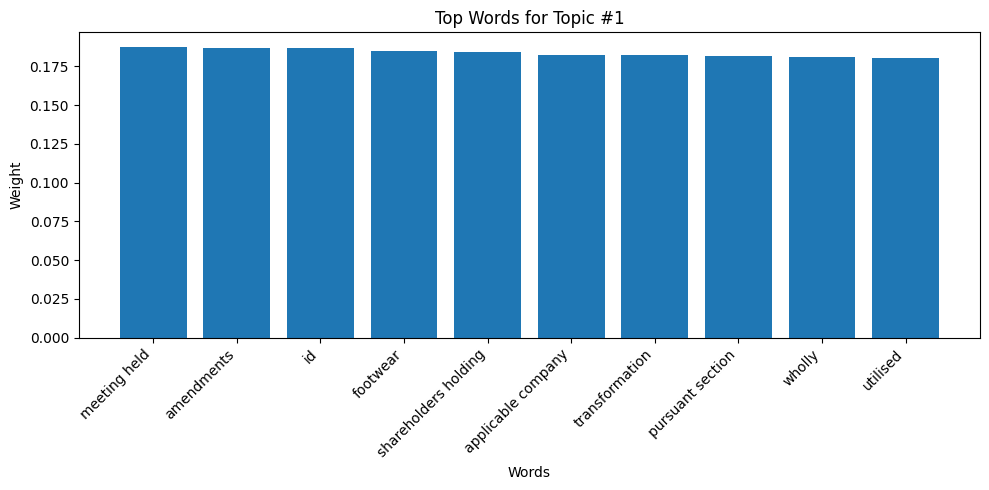

Topic #2: march | assets | year | liabilities | notes | ended march | year ended | ended | tax | cash


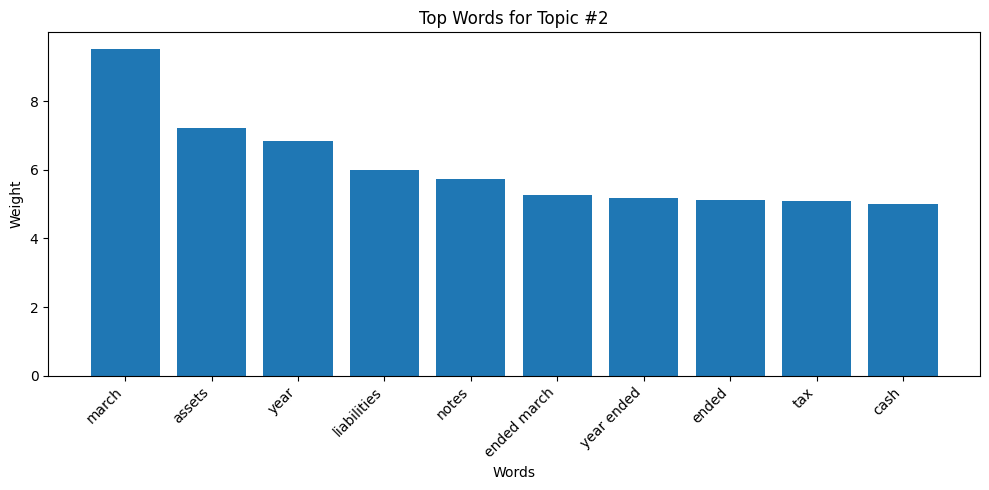

Topic #3: march | intensity | treatment | company | agency | total | current | external agency | form | independent


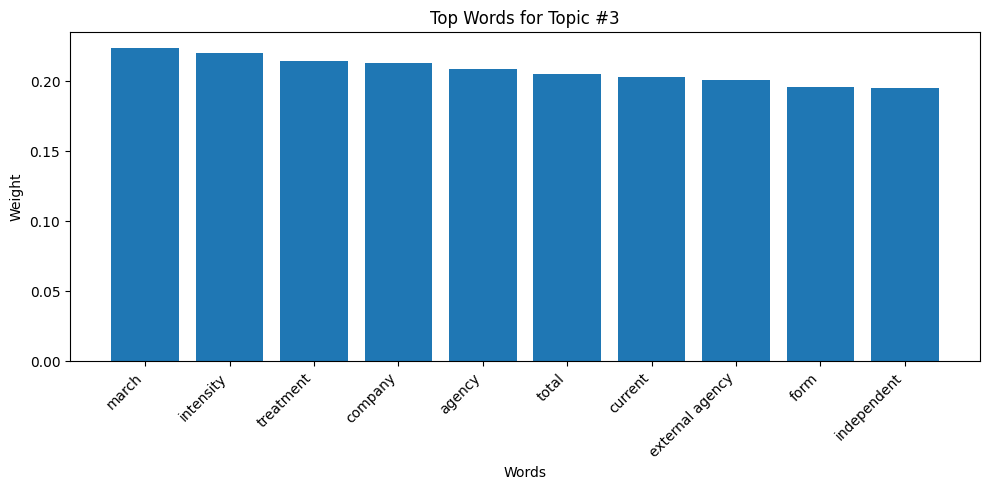

Topic #4: projects | march | year | attached | director | exchange | company | nil | total | companies


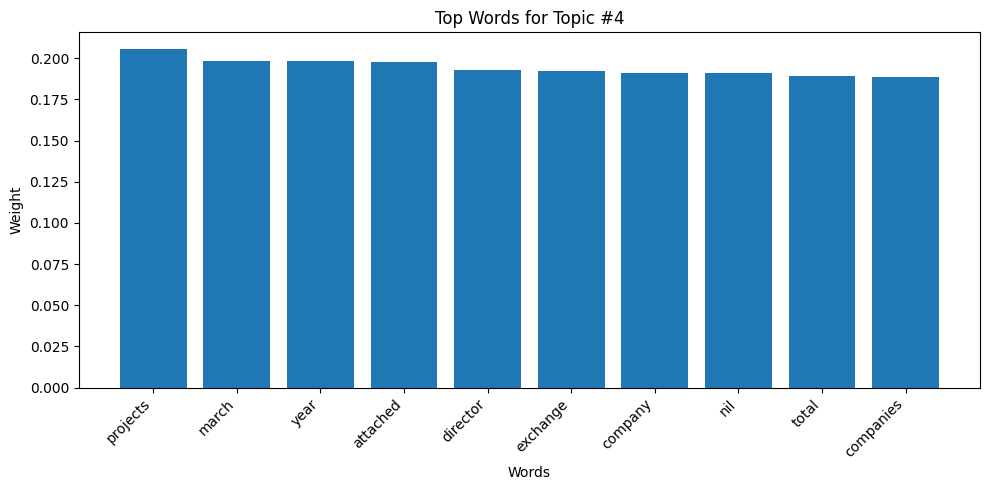

Topic #5: lal | weighted | loss year | present future | equivalents | purposes | end year | working capital | nil nil | transition


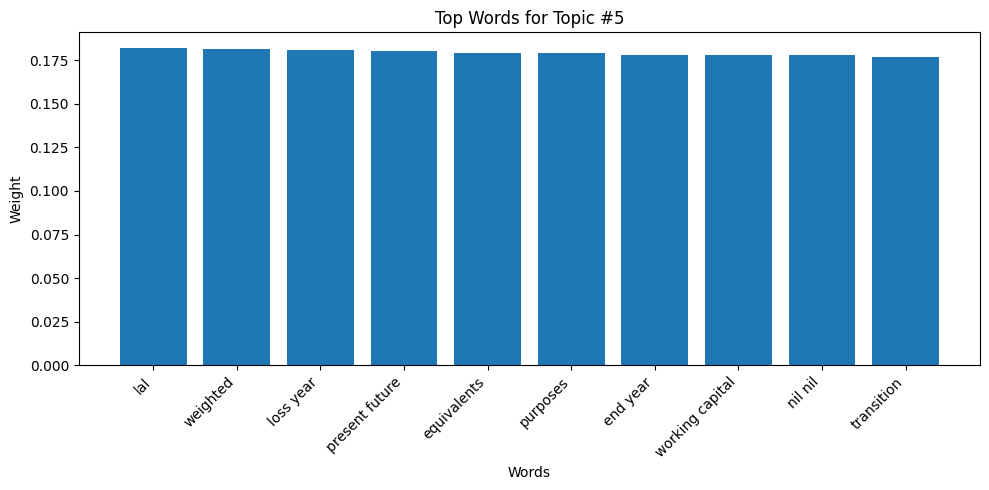

Topic #6: company | audit | nancial | year | board | nancial statements | directors | consolidated | holding | act


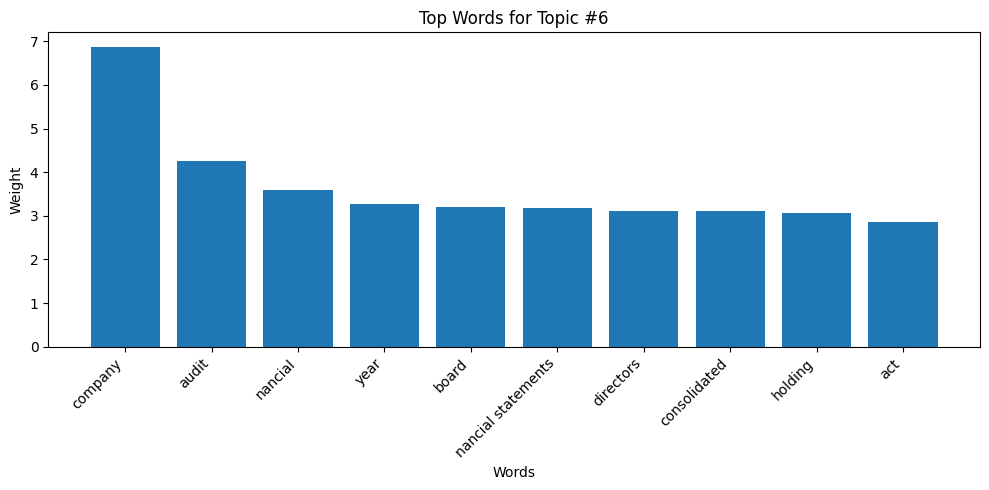

Topic #7: mn | manufactures | iso | description | detergent | capacity | liquid | care | powder | aggregate


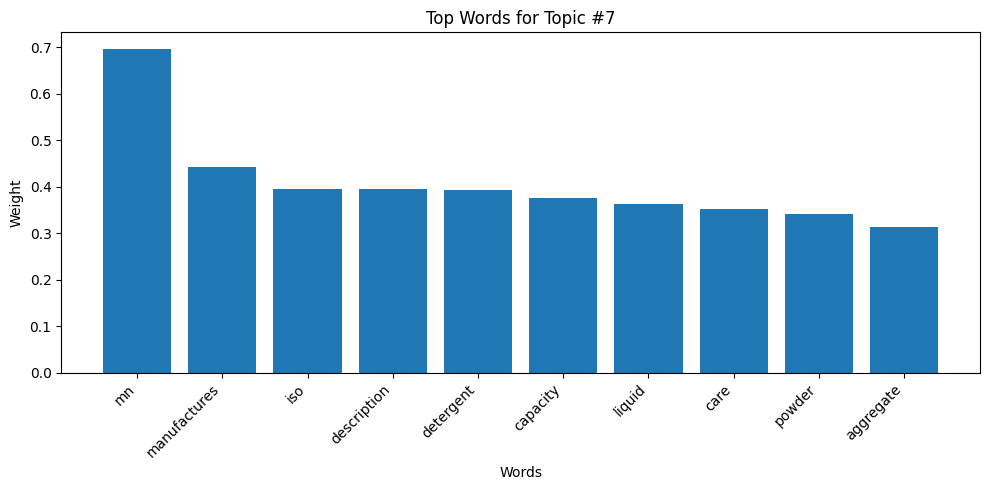

Topic #8: mr | company | director | csr | workers | exclusive charge | managing director | independent director | continue | directors


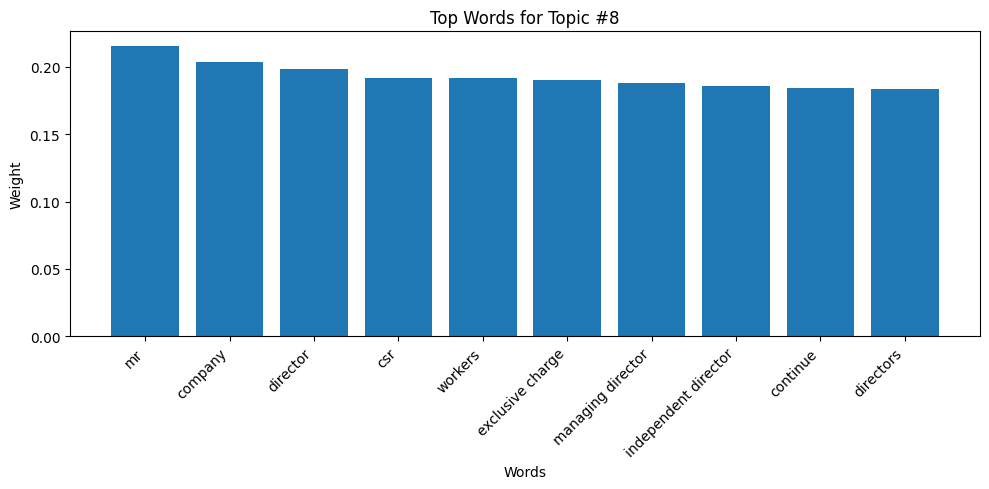

Topic #9: bahadur shastri | lal | city lal | shastri | bahadur | lal bahadur | th annual | agile | th | city


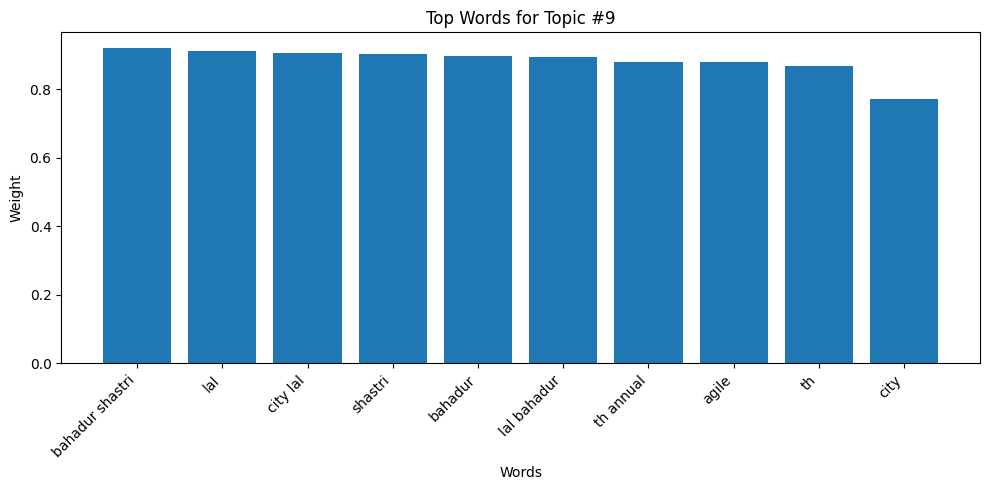

Topic #10: cy | growth | fmcg | global | indias | rural | source | economic | sector | bn


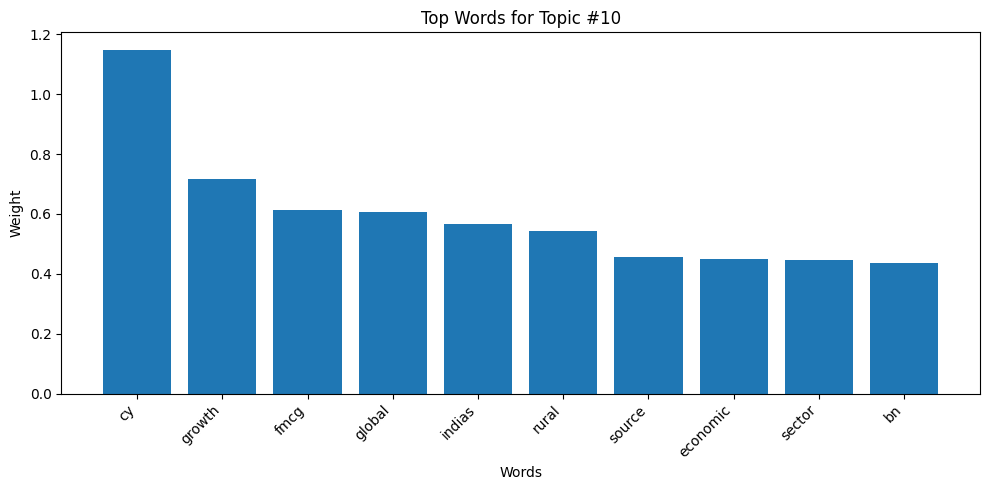


Topic modeling results saved to 'analysis_results.md'


===== Analysis Complete =====


In [37]:
print("\n--- Step 8: Building Topic Model (LDA) ---")
num_topics = 10

lda = LatentDirichletAllocation(n_components=num_topics,
                                random_state=42,
                                learning_method='online')
lda.fit(tfidf_matrix)

feature_names = vectorizer.get_feature_names_out()

# Save results to a markdown file
with open('analysis_results.md', 'w') as f:
    f.write("# Topic Modeling Results\n\n")
    print("\nTop words per topic:")

    for topic_idx, topic in enumerate(lda.components_):
        # Get top 10 words for this topic
        top_features_ind = topic.argsort()[:-11:-1]
        top_words = [feature_names[i] for i in top_features_ind]
        top_weights = topic[top_features_ind]

        print(f"Topic #{topic_idx + 1}: {' | '.join(top_words)}")

        # Write to file
        f.write(f"## Topic #{topic_idx + 1}\n")
        f.write(f"{' | '.join(top_words)}\n\n")
        # Visualize top words for each topic
        plt.figure(figsize=(10, 5))
        plt.bar(top_words, top_weights)
        plt.title(f'Top Words for Topic #{topic_idx + 1}')
        plt.xlabel('Words')
        plt.ylabel('Weight')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


print("\nTopic modeling results saved to 'analysis_results.md'")
print("\n\n===== Analysis Complete =====")